<a href="https://colab.research.google.com/github/sanjibani/RAG-learnings/blob/main/Rag2_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import getpass

if not os.environ.get("ANTHROPIC_API_KEY"):
  os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter anthropic api key")


Enter anthropic api key··········


In [2]:
pip install -U langchain-anthropic


In [3]:
from langchain.chat_models import init_chat_model
import os

llm = init_chat_model("claude-3-5-sonnet-latest", model_provider="anthropic", api_key=os.environ.get("ANTHROPIC_API_KEY"))

In [4]:
pip install -qU langchain-openai

In [5]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Enter API key for OpenAI: ··········


In [6]:
pip install -qU langchain-core

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [8]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [9]:
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


In [10]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [11]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [12]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [13]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
  """REtrieve information related to query"""
  retrieved_docs = vector_store.similarity_search(query , k=2)
  serialized = "\n\n".join(
      (f"Source: {doc.metadata}\nContent: {doc.page_content}")
  for doc in retrieved_docs
      )
  return serialized , retrieved_docs

In [14]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [15]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition


In [16]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

# Re-initialize the graph builder to start fresh
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("query_or_respond", query_or_respond)
graph_builder.add_node("tools", tools)
graph_builder.add_node("generate", generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

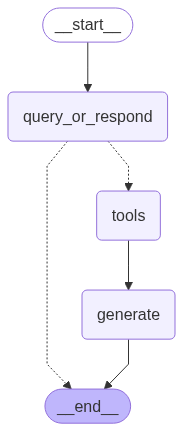

In [17]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! I'm here to help you retrieve information and answer your questions. Please feel free to ask anything specific you'd like to know, and I'll use the available tools to assist you.

I have access to a retrieval tool that can help find relevant information based on your queries. What would you like to know about?


In [19]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

[{'text': 'Let me retrieve information about Task Decomposition.', 'type': 'text'}, {'id': 'toolu_01SEe4tB93MSip4Pwp7CJEuz', 'input': {'query': 'What is task decomposition?'}, 'name': 'retrieve', 'type': 'tool_use'}]
Tool Calls:
  retrieve (toolu_01SEe4tB93MSip4Pwp7CJEuz)
 Call ID: toolu_01SEe4tB93MSip4Pwp7CJEuz
  Args:
    query: What is task decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite

In [20]:
input_message = "which one works the best mostof the time?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

which one works the best mostof the time?
================================== Ai Message ==================================

[{'text': 'Let me search for information about comparative effectiveness or performance.', 'type': 'text'}, {'id': 'toolu_01WieBz8WFAmYEKcZhupoemx', 'input': {'query': 'which solution works best most effective comparison'}, 'name': 'retrieve', 'type': 'tool_use'}]
Tool Calls:
  retrieve (toolu_01WieBz8WFAmYEKcZhupoemx)
 Call ID: toolu_01WieBz8WFAmYEKcZhupoemx
  Args:
    query: which solution works best most effective comparison
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: In comparison with three baselines, including ED (expert distillation, behavior cloning with expert trajectories instead of learning history), source policy (used for generating tr

In [21]:
from langgraph.checkpoint.memory import MemorySaver
memory= MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable":{"thread_id":"abc123"}}

In [22]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

[{'text': 'Let me retrieve information about Task Decomposition for you.', 'type': 'text'}, {'id': 'toolu_019Y4BAQZ4PRKo1BN2eXqrNx', 'input': {'query': 'What is Task Decomposition? Definition and explanation'}, 'name': 'retrieve', 'type': 'tool_use'}]
Tool Calls:
  retrieve (toolu_019Y4BAQZ4PRKo1BN2eXqrNx)
 Call ID: toolu_019Y4BAQZ4PRKo1BN2eXqrNx
  Args:
    query: What is Task Decomposition? Definition and explanation
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a stand

In [23]:
input_message = "which one works mostof the time?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

which one works mostof the time?
================================== Ai Message ==================================

[{'text': 'Let me retrieve information about the effectiveness of different task decomposition approaches.', 'type': 'text'}, {'id': 'toolu_01AGwwYptNnxXfTmGPGNqDNK', 'input': {'query': 'which task decomposition method is most effective or works best most of the time'}, 'name': 'retrieve', 'type': 'tool_use'}]
Tool Calls:
  retrieve (toolu_01AGwwYptNnxXfTmGPGNqDNK)
 Call ID: toolu_01AGwwYptNnxXfTmGPGNqDNK
  Args:
    query: which task decomposition method is most effective or works best most of the time
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals

In [24]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

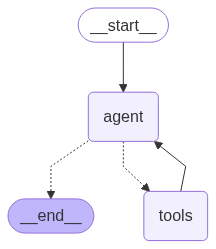

In [25]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

[{'text': "I'll help you search for information about standard task decomposition methods and then look for common extensions. Let me retrieve this information step by step.\n\nFirst, let's look up the standard method for task decomposition:", 'type': 'text'}, {'id': 'toolu_01CgG5eH48CZPRPjro3dUBSG', 'input': {'query': 'standard method task decomposition methodology steps'}, 'name': 'retrieve', 'type': 'tool_use'}]
Tool Calls:
  retrieve (toolu_01CgG5eH48CZPRPjro3dUBSG)
 Call ID: toolu_01CgG5eH48CZPRPjro3dUBSG
  Args:
    query: standard method task decomposition methodology steps
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lil